# load library

In [1]:
source("r/jupyter_common.R")

source("r/enrichment_analysis.R")
source("r/find_markers.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
# data structure
suppressPackageStartupMessages(library(stringi))
suppressPackageStartupMessages(library(forcats))

# utils
suppressPackageStartupMessages(library(amap)) # for Dist()
suppressPackageStartupMessages(library(matrixStats))
suppressPackageStartupMessages(library(scales))

# scRNA-seq
suppressPackageStartupMessages(library(Seurat))



## parallel

In [3]:
suppressPackageStartupMessages(library(future))
plan("multicore", workers = 8)

options(future.globals.maxSize = 5 * 1024^3) # 5GB


# parameters

In [4]:
cancer_type <- "normal-breast-pairs"

args <- list()
args$cancer_type <- "normal-breast"
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$seurat_resolution <- 0.8
args$harmony_theta <- 0

str_column_of_meta_data_cluster <- sprintf("RNA_snn_res.%g", args$seurat_resolution)
str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "cluster.type"

str_condition <- cancer_type

str_condition
str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types

figure_format <- "pdf"



[1] "normal-breast-pairs"

[1] "RNA_snn_res.0.8"

[1] "umap"

[1] "cluster.type"

## set.seed

In [5]:
# set seed for reproducibility
set.seed(51)



## display

In [6]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=50)


## nv_cell_type_conversion_table

In [7]:
nv_cell_type_conversion_table <- c(
    "LEp_prog"="Luminal epi. prog",
    "LEp_secretory"="Luminal epi. secretory",
    "LEp"="Mature luminal epi.",
    "LEp_hormone"="Luminal epi. hormone",
    "BEp"="Basal epi.",
    "BEp_myo"="Basal epi. myoepithelial")


# read scRNA-seq

In [8]:

dir_rna <- "/home/hkim77/spanheimer_lab.w/sc-rna-seq/tr-bc/run-20220121"
fname_rna <- sprintf("%s/output/rds_%s/%s_sc-rna-seq_merged_seurat_obj.rds", dir_rna,
                    cancer_type, cancer_type)

rna <- readRDS(fname_rna)



## mapping sample IDs

In [9]:
df_id_map <- read.table("tsv/sample_id_mapping_table.tsv",
                     sep="\t",
                     header=T,
                     row.names=1)

idx <- match(rna@meta.data$Sample, rownames(df_id_map))
rna@meta.data$Sample <- df_id_map[idx, 1]


## n_samples

In [10]:
samples <- unique(rna@meta.data$Sample)
samples

n_samples <- length(samples)
n_samples


[1] "Normal_01_Control"   "Normal_01_Tamoxifen" "Normal_02_Control"  
[4] "Normal_02_Tamoxifen"

[1] 4

## list_samples

In [11]:
list_samples <- list()

u_samples <- unique(gsub("_Control|_Tamoxifen", "", samples))
for (sample in u_samples) {
    list_samples[[sample]]$control <- sprintf("%s_Control", sample)
    list_samples[[sample]]$treatment <- sprintf("%s_Tamoxifen", sample)
}

list_samples
length(list_samples)


$Normal_01
$Normal_01$control
[1] "Normal_01_Control"

$Normal_01$treatment
[1] "Normal_01_Tamoxifen"


$Normal_02
$Normal_02$control
[1] "Normal_02_Control"

$Normal_02$treatment
[1] "Normal_02_Tamoxifen"

[1] 2

## mtx

In [12]:
if (DefaultAssay(rna) == "integrated") {
    mtx <- GetAssayData(object = rna, assay=NULL, slot = "data")
} else {
    mtx <- GetAssayData(object = rna, assay="RNA", slot = "data")
}
head(mtx[,1:3])


6 x 3 sparse Matrix of class "dgCMatrix"
           49758L_12hrSUS_E2#AAACCCAAGTCAGGGT-1
AL627309.1                                    .
AL669831.2                                    .
AL669831.5                                    .
FAM87B                                        .
LINC00115                                     .
FAM41C                                        .
           49758L_12hrSUS_E2#AAACCCACATCACAGT-1
AL627309.1                                    .
AL669831.2                                    .
AL669831.5                                    .
FAM87B                                        .
LINC00115                                     .
FAM41C                                        .
           49758L_12hrSUS_E2#AAACCCATCTCAATCT-1
AL627309.1                                    .
AL669831.2                                    .
AL669831.5                                    .
FAM87B                                        .
LINC00115                                     .

## list_sort

In [13]:

list_sort <- sort_cluster_members(rna, args,
                    col_cluster_types = col_cluster_types,
                    str_umap_reduction = str_umap_reduction,
                    f_merge_immune_cell = FALSE)


## colors

### samples

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C"

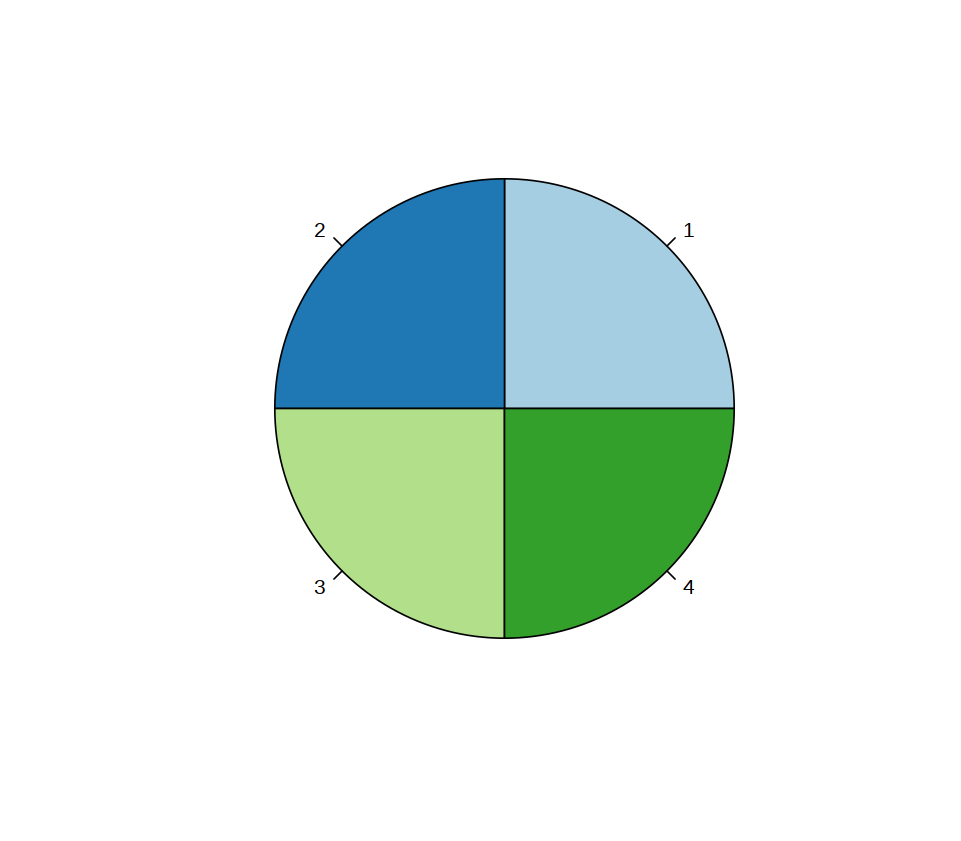

In [14]:
# make patient sample metadata and color assignments 

if (n_samples <= 12){
    sampleColors <- brewer.pal(n_samples, "Paired")
} else {
    vec_color1 <- colorRampPalette(brewer.pal(9, "Set1"))(n_samples/2)
    vec_color2 <- colorspace::lighten(vec_color1, amount=0.4)
    sampleColors <- c(rbind(vec_color1, vec_color2))
}
sampleColors

options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1,n_samples), col=sampleColors) 


### epi

[1] "Epithelial cells" "Epi. Non-tumor"   "LEp_prog"         "LEp_secretory"   
 [5] "LEp"              "LEp_hormone"      "BEp"              "BEp_MaSCs"       
 [9] "BEp_myo"          "Epi. Unassigned"  "Epi. Tumor"       "Normal-like"     
[13] "NBL"              "Basal"            "CLow"             "Her2E"           
[17] "LumA"             "LumB"             "Keratinocytes"

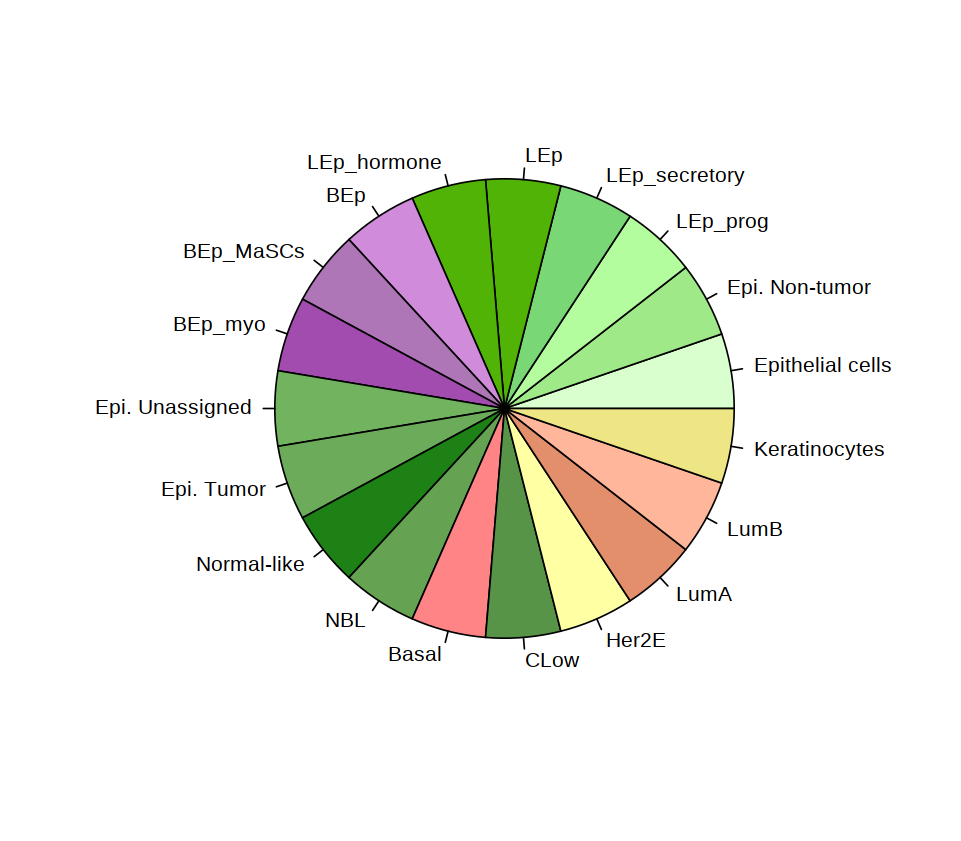

In [15]:
idx_epi <- grep(pattern_epi, names(nv_color))
names(nv_color)[idx_epi]
# http://applied-r.com/rcolorbrewer-palettes/
colors_epi <- RColorBrewer::brewer.pal(9, "Set1")
colors_epi <- colorspace::lighten(colors_epi, amount=0.4)

nv_color["Epithelial cells"] <- "#d9ffcf"
nv_color["LEp_prog"] <- "#b4fd9e"
nv_color["LEp_secretory"] <- colors_epi[3]
color_lep_mature <- colorspace::darken(nv_color["LEp_prog"], amount=0.3)
nv_color["LEp"] <- color_lep_mature
nv_color["LEp_hormone"] <- color_lep_mature

nv_color["BEp"] <- colors_epi[4]
color_bep_mascs <- colorspace::darken(nv_color["BEp"], amount=0.15)
color_bep_myo <- colorspace::darken(nv_color["BEp"], amount=0.3)
nv_color["BEp_MaSCs"] <- color_bep_mascs
nv_color["BEp_myo"] <- color_bep_myo

nv_color["Basal"] <- colors_epi[1]
nv_color["Her2E"] <- colors_epi[6]
nv_color["Her2"] <- colors_epi[6]
nv_color["LumA"] <- colors_epi[7]
nv_color["LumB"] <- colors_epi[5]
nv_color["Normal-like"] <- colorspace::darken(colors_epi[3], amount=0.4)

pie(rep(1, length(idx_epi)), col=nv_color[idx_epi],
       labels=names(nv_color)[idx_epi]) 

                                       

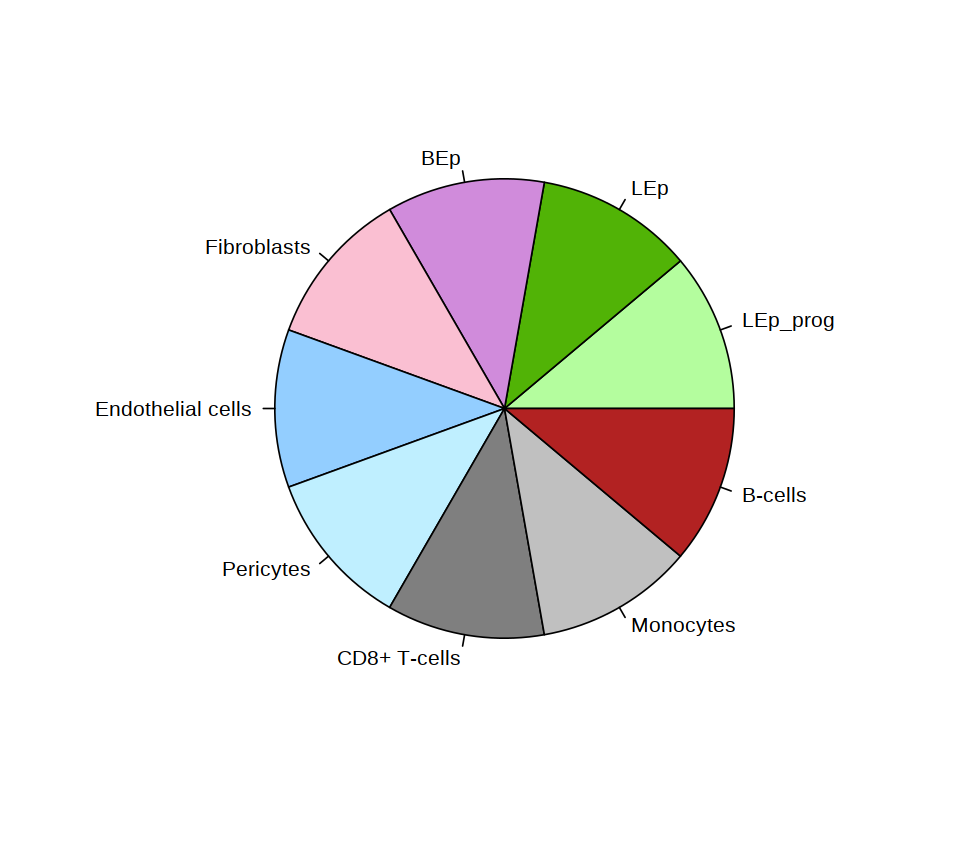

In [16]:
list_sort <- update_nv_color_cell_type(list_sort)
colors_epi <- list_sort$nv_color_cell_type

pie(rep(1, length(colors_epi)), col=colors_epi,
       labels=names(colors_epi)) 


### cell.type

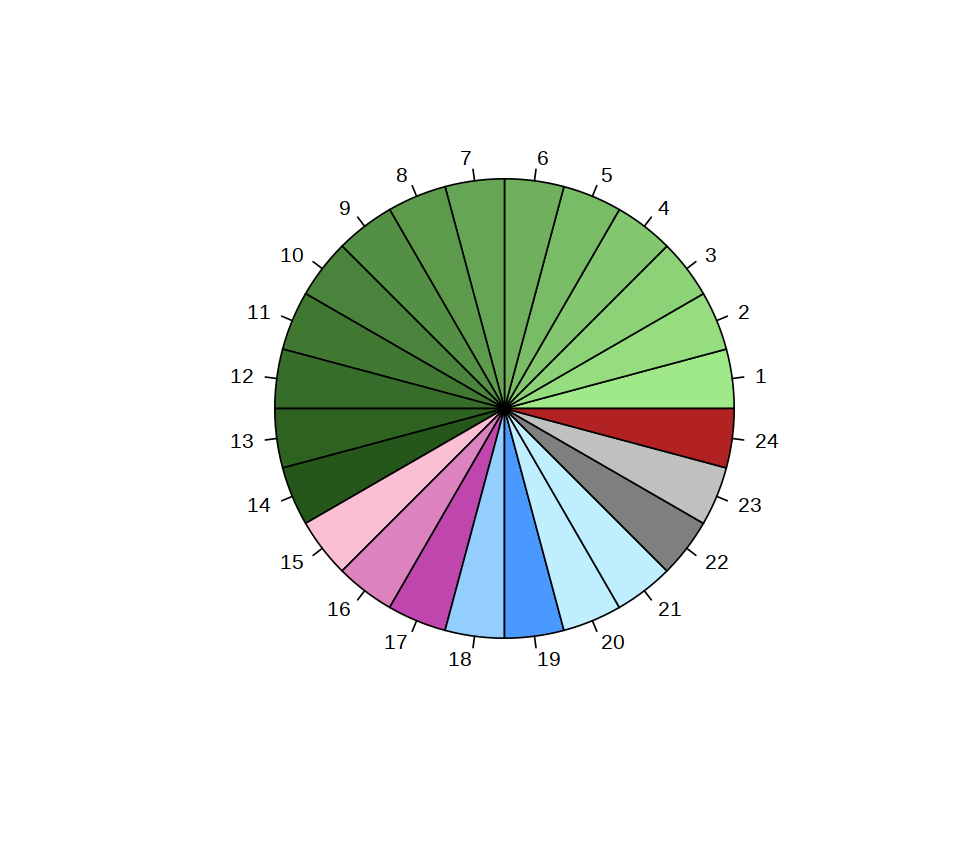

In [17]:
options(repr.plot.width=8.01, repr.plot.height=7.01)
pie(rep(1, length(list_sort$nv_color_cluster_type_ordered)),
    col=list_sort$nv_color_cluster_type_ordered) 


# DGE

In [18]:

method_dge <- "seurat_findmarkers_enricher"
dir_xlsx <- "xlsx"

#method_dge <- "presto_wilcoxauc_gsea"
#dir_xlsx <- "xlsx/gsea"

list_genes_dn <- list()




## gmt

In [19]:

list_gmt <- list()
list_gmt[["h"]] <- read.gmt("reference/gmt/h.all.v6.1.symbols.gmt")
list_gmt[["unc_lccc"]] <- read.gmt("reference/gmt/pubmed21214954_human_gene_signatures.gmt")


## all samples

In [20]:
# tumor pairs with large differences

sample1 <- NULL
sample_ref <- NULL

# for stronger signal
th_log2fc_=0.25; th_padj_=0.01

min.pct_=0.25; min.diff.pct_=-Inf; max.cells.per.ident_=Inf

f_featureplot=FALSE
n_sampling=-1
cluster_rows=FALSE

pattern_sample1 <- "Tamoxifen"
pattern_sample_ref <- NULL

drug_name <- "tamoxifen"
group_name1 <- "tamoxifen"
group_name_ref <- "control"

col_cluster_types_ <- NULL
col_cell_types_ <- "cell.type"


## cell types

BEp

assay=integrated, slot=data

tamoxifen BEp n_idx1: 659, samples: Normal_01_Tamoxifen, Normal_02_Tamoxifen

control BEp n_idx_ref: 797, samples: Normal_01_Control, Normal_02_Control

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT2A,1.085772e-42,0.7511993,0.985,0.932,2.571651e-38,0.00000000,4.069704,6.282148
MT1E,1.438730e-39,0.9152067,0.854,0.507,3.407631e-35,-0.45548323,1.576421,5.483074
MT1X,7.099808e-37,0.8024920,0.889,0.509,1.681589e-32,-0.08134671,1.759772,4.786647
SOD2,1.743243e-35,0.6860339,0.961,0.975,4.128872e-31,-0.58317636,2.550869,4.649310
FTL,2.458278e-32,0.6670440,1.000,0.999,5.822432e-28,1.22202765,3.913800,5.858428
SQSTM1,7.569035e-32,0.4785543,0.985,0.981,1.792726e-27,0.00000000,2.272496,4.479459


[1] 114   8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT-CO3,5.314010e-53,-0.7946342,0.954,0.989,1.258623e-48,0.0000000,1.9216519,5.079960
MT-CO1,4.844225e-51,-0.5765198,0.977,0.994,1.147355e-46,0.0000000,2.4336504,5.307871
MT-ATP6,4.702082e-49,-0.7478216,0.951,0.990,1.113688e-44,0.0000000,2.1544117,5.792396
MT-ND4,2.672247e-43,-0.5980571,0.942,0.984,6.329216e-39,0.0000000,1.8818140,5.033736
KRT19,4.359095e-41,-0.9500336,0.385,0.678,1.032452e-36,-0.8913593,0.5676338,5.128677
MT-ND1,2.939077e-39,-0.6359537,0.920,0.965,6.961203e-35,0.0000000,1.6657561,4.898882


[1] 76  8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,24/77,200/4386,1.105290e-14,4.531689e-13,3.025004e-13,SOD2/SQSTM1/GEM/TNFAIP3/HBEGF/ICAM1/TNC/IL6/NFIL3/CDKN1A/KDM6B/NFKB1/LIF/PLAU/ZFP36/MAP2K3/VEGFA/TNFAIP6/EGR1/CXCL1/GADD45A/FOS/SOCS3/CCNL1,24
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,16/77,200/4386,2.240736e-07,4.593509e-06,3.066270e-06,TPM2/FGF2/GEM/TAGLN/TNFAIP3/GPC1/TNC/MMP14/IL6/IL32/LGALS1/VEGFA/SPP1/ACTA2/CXCL1/GADD45A,16
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,15/77,200/4386,1.309958e-06,1.790275e-05,1.195049e-05,MT2A/MT1E/SLC2A1/CSRP2/TNFAIP3/HMOX1/GPC1/DDIT3/IL6/CAV1/NFIL3/CDKN1A/ZFP36/VEGFA/FOS,15
HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,13/77,200/4386,3.469014e-05,3.555740e-04,2.373536e-04,HBEGF/HMOX1/DDIT3/CCND2/SERPINB5/CDKN1A/LIF/KRT17/SFN/GADD45A/FOS/RGS16/HINT1,13
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,12/77,200/4386,1.559284e-04,1.278613e-03,8.535030e-04,SQSTM1/SLC2A1/FAM129A/DDIT3/SLC1A5/IFRD1/NFIL3/CDKN1A/HSPD1/INSIG1/MAP2K3/HSP90B1,12
HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,5/77,49/4386,1.526317e-03,8.750451e-03,5.841123e-03,SOD2/FTL/PRNP/TXN/GCLM,5


[1] 12  9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Lim.et.al.2010.Conserved.aMaSC_BCR.2010_PMID.20346151,Lim.et.al.2010.Conserved.aMaSC_BCR.2010_PMID.20346151,Lim.et.al.2010.Conserved.aMaSC_BCR.2010_PMID.20346151,31/113,488/19982,3.673670e-24,9.478068e-22,5.955212e-22,GYPC/TPM2/GEM/TAGLN/CSRP2/CLMP/PRNP/DKK3/NRP2/ICAM1/COL17A1/BAG3/CCND2/SLC1A5/NXN/IL6/KRT14/CAV1/APOE/CDKN1A/CTNNAL1/ACTG2/LGALS1/TINAGL1/CRYAB/FAT1/VSNL1/CPNE8/ACTA2/EPAS1/KRT5,31
Pfefferle2012_MaSC_Adam_PMID.25575446,Pfefferle2012_MaSC_Adam_PMID.25575446,Pfefferle2012_MaSC_Adam_PMID.25575446,17/113,180/19982,2.350207e-16,3.031767e-14,1.904904e-14,FAM129A/PRNP/HBEGF/GPC1/DKK3/NRP2/COL17A1/KRT14/SERPINB5/CTNNAL1/ACTG2/TUBB2B/TINAGL1/ANO1/AGPAT5/GCLM/KRT5,17
Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,13/113,141/19982,1.289282e-12,1.108783e-10,6.966648e-11,SOD2/SQSTM1/GEM/SPRY2/TNFAIP3/HMOX1/ICAM1/IFRD1/NFIL3/CDKN1A/KDM6B/MAP2K3/GADD45A,13
MDSC_Neutrophil_Youn_J_Leukoc_Biol.2012_PMID.21954284,MDSC_Neutrophil_Youn_J_Leukoc_Biol.2012_PMID.21954284,MDSC_Neutrophil_Youn_J_Leukoc_Biol.2012_PMID.21954284,8/113,29/19982,3.162374e-12,2.039731e-10,1.281594e-10,MT2A/SOD2/ICAM1/CCND2/MMP14/IL6/SPP1/CXCL1,8
MDSC_tumor_MO_Schlecker_J.Immunol.2012_PMID.23152559,MDSC_tumor_MO_Schlecker_J.Immunol.2012_PMID.23152559,MDSC_tumor_MO_Schlecker_J.Immunol.2012_PMID.23152559,12/113,129/19982,8.863123e-12,4.573372e-10,2.873518e-10,SLC2A1/HMOX1/DDIT3/MMP14/CDKN1A/ZFP36/VEGFA/EGR1/SPP1/CXCL1/GADD45A/RGS16,12
UNC_HS_Red8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red8_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red8_BMC.Med.Genomics.2011_PMID.21214954,17/113,358/19982,1.835723e-11,7.893608e-10,4.959672e-10,MT1E/MT1X/TPM2/CSRP2/SPRY2/COL17A1/SLC43A3/KRT14/IFRD1/SERPINB5/ACTG2/KRT17/CRYAB/FAT1/CXCL1/KRT5/CCNL1,17


[1] 93  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,9/42,200/4386,8.553934e-05,0.002993877,0.002791284,KRT19/KRT18/KRT8/TGM2/CCND1/MUC1/PRSS23/KRT15/ELF3,9
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,6/42,101/4386,3.442149e-04,0.006023761,0.005616138,KRT19/AZGP1/KRT8/SAT1/CCND1/ALDH1A3,6
HALLMARK_APOPTOSIS,HALLMARK_APOPTOSIS,HALLMARK_APOPTOSIS,7/42,161/4386,7.188907e-04,0.008387058,0.007819513,KRT18/SAT1/CCND1/TNFSF10/LMNA/GPX4/TSPO,7


[1] 3 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,21/64,277/19982,1.069869e-23,1.840175e-21,1.103655e-21,KRT19/CD24/KRT18/KRT8/S100A6/FXYD3/ALDH1A3/ATP1B1/KRT15/S100A9/VAMP8/S100A14/RBM47/CLDN4/TC2N/SPINT2/ELF3/KYNU/LMNA/LYPD3/MAL2,21
UNC_MM_Green9_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Green9_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Green9_BMC.Med.Genomics.2011_PMID.21214954,13/64,356/19982,8.485502e-11,7.297532e-09,4.376733e-09,KRT19/KRT18/WFDC2/ATP1B1/PERP/EZR/RBM47/CLDN4/CRYBG1/SPINT2/ELF3/LYPD3/MAL2,13
Claudin_Low_Genome.Biol.2007_PMID.17493263,Claudin_Low_Genome.Biol.2007_PMID.17493263,Claudin_Low_Genome.Biol.2007_PMID.17493263,11/64,244/19982,3.021169e-10,1.732137e-08,1.038858e-08,KRT19/AZGP1/KRT18/FXYD3/MUC1/PERP/S100A14/CLDN4/SPINT2/ELF3/MAL2,11
EMT_DOWN_Weingberg_PNAS.2010_PMID.20713713,EMT_DOWN_Weingberg_PNAS.2010_PMID.20713713,EMT_DOWN_Weingberg_PNAS.2010_PMID.20713713,9/64,158/19982,1.825297e-09,7.848778e-08,4.707345e-08,KRT18/ALDH1A3/KRT15/KRT16/DSC2/PERP/S100A14/SLPI/SPINT2,9
Stromal_Down_Nat.Med.2009_PMID.19648928,Stromal_Down_Nat.Med.2009_PMID.19648928,Stromal_Down_Nat.Med.2009_PMID.19648928,11/64,347/19982,1.209122e-08,4.159379e-07,2.494609e-07,KRT8/ACTG1/VAMP8/KRT16/DSC2/PERP/EZR/S100A14/SPINT2/TSPO/MAL2,11
Claudin_Low_29_Cancer.Res.2009_PMID.19435916,Claudin_Low_29_Cancer.Res.2009_PMID.19435916,Claudin_Low_29_Cancer.Res.2009_PMID.19435916,5/64,26/19982,1.794908e-08,5.145402e-07,3.085982e-07,FXYD3/CLDN4/SPINT2/ELF3/MAL2,5


[1] 46  9

filename_xlsx: xlsx/normal-breast-pairs_control_vs_tamoxifen_BEp.xlsx

filename_figure: heatmap_normal-breast-pairs_control_vs_tamoxifen_BEp_no_down_mcf7.e2.induced.genes_zscore

LEp_prog

assay=integrated, slot=data

tamoxifen LEp_prog n_idx1: 2410, samples: Normal_01_Tamoxifen, Normal_02_Tamoxifen

control LEp_prog n_idx_ref: 3211, samples: Normal_01_Control, Normal_02_Control

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MT1M,1.688899e-242,0.6655861,0.447,0.057,4.000158e-238,-0.2192190,0.3655056,2.867486
SLC30A1,1.075206e-220,0.4430192,0.530,0.117,2.546624e-216,-0.1032656,0.3509082,2.357005
SQSTM1,1.020829e-205,0.5240438,0.995,0.988,2.417833e-201,0.0000000,2.1377009,4.663515
CXCL8,1.517554e-197,1.2811797,0.946,0.954,3.594328e-193,-0.1888420,2.5409604,6.017399
MT2A,8.644310e-190,1.1709810,0.989,0.926,2.047405e-185,0.0000000,2.9918100,6.596021
SPAG9,5.257315e-187,0.7573787,0.902,0.702,1.245195e-182,0.0000000,1.2690168,2.842295


[1] 285   8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A10,0,-1.065813,0.970,0.996,0,-0.1366832,2.2635748,4.918772
S100A6,0,-1.368022,0.998,1.000,0,0.0000000,2.7032959,5.504203
ACTB,0,-1.123139,0.994,0.997,0,0.0000000,2.4312526,4.764856
AZGP1,0,-1.316638,0.711,0.941,0,-1.1890470,0.5954715,4.865499
CD9,0,-1.084422,0.855,0.936,0,-0.7169299,0.8954627,3.321943
MGP,0,-1.155150,0.912,0.964,0,-0.7262379,0.9215396,5.769526


[1] 536   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,60/158,200/4386,2.519290e-42,1.184066e-40,7.425274e-41,SQSTM1/KDM6B/PNRC1/PPP1R15A/SOD2/GEM/TNFAIP3/NFIL3/REL/CCNL1/IL6/NR4A1/FOS/NFKB1/FOSB/NFKBIA/HBEGF/ZBTB10/ICAM1/ATF3/KLF9/NFAT5/DUSP5/PDE4B/KLF4/ZFP36/INHBA/PTGS2/DNAJB4/EGR1/GADD45A/TIPARP/MCL1/NFE2L2/GADD45B/BHLHE40/NR4A2/VEGFA/CDKN1A/LIF/NAMPT/MYC/IRF1/SOCS3/HES1/TNFAIP6/TRIB1/CXCL2/MAP2K3/ETS2/BTG1/CEBPB/IER5/JUN/G0S2/KLF10/CXCL3/SERPINE1/JUNB/CXCL1,60
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,29/158,200/4386,4.534647e-11,1.065642e-09,6.682638e-10,MT2A/PNRC1/PPP1R15A/HMOX1/TNFAIP3/DDIT3/MT1E/NFIL3/IL6/FOS/ATF3/NDRG1/ZFP36/DDIT4/ETS1/CSRP2/TIPARP/NR3C1/PLIN2/BHLHE40/WSB1/VEGFA/CDKN1A/PIM1/CAV1/HSPA5/BTG1/JUN/SERPINE1,29
HALLMARK_UV_RESPONSE_UP,HALLMARK_UV_RESPONSE_UP,HALLMARK_UV_RESPONSE_UP,19/158,158/4386,2.706236e-06,4.239770e-05,2.658758e-05,SQSTM1/HMOX1/SOD2/IL6/NR4A1/FOS/FOSB/NFKBIA/ICAM1/ATF3/HSPA13/DDX21/DNAJA1/DNAJB1/IRF1/EIF5/CXCL2/BTG1/JUNB,19
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,21/158,200/4386,7.092643e-06,8.333856e-05,5.226158e-05,GEM/TNFAIP3/IL6/DAB2/VIM/TIMP3/FGF2/INHBA/COL4A1/GADD45A/GADD45B/PRRX1/SERPINE2/SPARC/VEGFA/JUN/TFPI2/MMP3/LGALS1/SERPINE1/CXCL1,21
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,20/158,200/4386,2.482021e-05,2.333100e-04,1.463086e-04,SQSTM1/PPP1R15A/INSIG1/DDIT3/NFIL3/IFRD1/FAM129A/IDI1/TXNRD1/DDIT4/HSP90B1/BHLHE40/MTHFD2/LGMN/CDKN1A/HSPA9/NAMPT/HSPA5/MAP2K3/ETF1,20
HALLMARK_APOPTOSIS,HALLMARK_APOPTOSIS,HALLMARK_APOPTOSIS,17/158,161/4386,5.283092e-05,4.138422e-04,2.595203e-04,SQSTM1/HMOX1/SOD2/DDIT3/IL6/CYLD/ATF3/TIMP3/GADD45A/MCL1/GADD45B/DNAJA1/CDKN1A/IRF1/CAV1/ETF1/JUN,17


[1] 16  9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,38/281,141/19982,3.405637e-38,1.106832e-35,7.779193e-36,SQSTM1/KDM6B/HMOX1/SOD2/GEM/TNFAIP3/NFIL3/REL/NR4A1/IFRD1/FOSB/NFKBIA/ICAM1/ATF3/ARL5B/SPRY2/DUSP5/RYBP/DENND4A/NFKBIZ/DNAJB4/GADD45A/TIPARP/NFE2L2/GADD45B/NR4A2/CDKN1A/CREM/PIM1/TRIB1/MAP2K3/CEBPB/IER5/JUN/HSPA1A/CXCL3/SKIL/JUNB,38
GSEA_GP15_EGF_signailng.r=0.936_NAGASHIMA_EGF_SIGNALING_UP,GSEA_GP15_EGF_signailng.r=0.936_NAGASHIMA_EGF_SIGNALING_UP,GSEA_GP15_EGF_signailng.r=0.936_NAGASHIMA_EGF_SIGNALING_UP,26/281,58/19982,3.249587e-33,5.280578e-31,3.711370e-31,KDM6B/GEM/NR4A1/FOS/FOSB/HBEGF/ATF3/DUSP5/RYBP/ZFP36/EGR1/KBTBD2/TIPARP/MCL1/BHLHE40/NR4A2/LIF/DNAJB1/MYC/HES1/TRIB1/ETS2/JUN/ID3/KLF10/JUNB,26
TCGA.BRCA.1198_immune_FOS_JUN_IL6_Cell.2015_PMID.26451490,TCGA.BRCA.1198_immune_FOS_JUN_IL6_Cell.2015_PMID.26451490,TCGA.BRCA.1198_immune_FOS_JUN_IL6_Cell.2015_PMID.26451490,11/281,14/19982,1.226614e-18,1.328832e-16,9.339483e-17,PPP1R15A/IL6/NR4A1/FOSB/HBEGF/ATF3/CSRNP1/ZFP36/EGR1/SOCS3/JUN,11
Tcell_EXH_Exhausted_CD8_T_cell_vs_Naive_CD8_T_cell_Metagene_1_Science.2016_PMID.27789795,Tcell_EXH_Exhausted_CD8_T_cell_vs_Naive_CD8_T_cell_Metagene_1_Science.2016_PMID.27789795,Tcell_EXH_Exhausted_CD8_T_cell_vs_Naive_CD8_T_cell_Metagene_1_Science.2016_PMID.27789795,22/281,127/19982,5.247955e-18,4.263963e-16,2.996858e-16,SOD2/GEM/TNFAIP3/NFIL3/NR4A1/IRAK2/NFKBIA/IFI16/ATF3/ARL5B/DUSP5/RYBP/DENND4A/NFKBIZ/EGR1/GADD45B/NR4A2/CDKN1A/CREM/NAMPT/CEBPB/CXCL3,22
UNC_HS_Red24_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red24_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red24_BMC.Med.Genomics.2011_PMID.21214954,16/281,52/19982,1.003842e-17,6.524972e-16,4.585972e-16,GEM/IL6/NR4A1/FOS/FOSB/HBEGF/ATF3/KLF4/ZFP36/PTGS2/EGR1/NR4A2/TRIB1/JUN/SERPINE1/JUNB,16
FOS_JUN_Cluster_BMC.Med.Genomics.2011_PMID.21214954,FOS_JUN_Cluster_BMC.Med.Genomics.2011_PMID.21214954,FOS_JUN_Cluster_BMC.Med.Genomics.2011_PMID.21214954,10/281,16/19982,1.916423e-15,1.038062e-13,7.295854e-14,PPP1R15A/GEM/NR4A1/FOS/FOSB/ATF3/ZFP36/EGR1/JUN/JUNB,10


[1] 88  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_OXIDATIVE_PHOSPHORYLATION,45/275,200/4386,6.599832e-15,3.233918e-13,2.848349e-13,LDHA/ATP1B1/CYB5A/NDUFV2/COX4I1/NDUFA4/COX6C/GPX4/ATP6V0B/MGST3/COX6A1/NDUFC2/COX7A2/COX7C/COX5B/NDUFB7/UQCR10/COX5A/NDUFB2/IDH2/NDUFS6/VDAC2/ATP6V1G1/SLC25A3/COX6B1/ATP6V0E1/NDUFAB1/UQCR11/TIMM13/MDH2/UQCRFS1/COX8A/NDUFS8/UQCRB/TIMM8B/VDAC1/ATP6V1F/NDUFB8/UQCRQ/VDAC3/ECHS1/PRDX3/MRPS15/COX17/NDUFC1,45
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,39/275,200/4386,6.082563e-11,1.490228e-09,1.312553e-09,LDHA/PHB/SSBP1/PSMD8/RPL14/PPIA/NME1/YWHAQ/COX5A/PSMB3/PGK1/CCT5/PSMA4/C1QBP/PSMB2/SNRPD3/CCT3/RANBP1/SLC25A3/RPL22/NDUFAB1/CBX3/TXNL4A/TUFM/PSMA7/LSM7/PSMA1/LSM2/PRDX4/ACP1/SNRPD1/VDAC1/UBE2L3/VDAC3/SNRPD2/NHP2/CCT7/PRDX3/PA2G4,39
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,16/275,101/4386,4.605441e-04,7.522221e-03,6.625372e-03,AZGP1/KRT8/KRT19/MYL12A/SAT1/ACTN1/CCND1/PMEPA1/STEAP4/PDLIM5/SMS/TMEM50A/DBI/H1F0/ADRM1/PA2G4,16


[1] 3 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,53/515,277/19982,7.546456e-31,2.686538e-28,1.898530e-28,S100A6/CD9/KRT7/KRT8/KRT18/KRT19/CD24/S100A14/TACSTD2/S100A16/DSTN/TM4SF1/SPINT2/VAMP8/S100A9/MGST1/ATP1B1/S100A11/LMNA/ELF3/CLDN4/FXYD3/CALM1/CLDN7/RAC1/EIF6/LYPD3/KCNMA1/KRT15/SQOR/JUP/MAL2/HSPB1/EPCAM/TC2N/TSPAN15/MYOF/S100A4/GATA3/OCIAD2/ADIRF/RER1/FOXA1/MRPL13/RBM47/MLPH/ISG20/DUSP23/MGLL/CSRP1/NDUFB9/SPINT1/MALL,53
Stromal_Down_Nat.Med.2009_PMID.19648928,Stromal_Down_Nat.Med.2009_PMID.19648928,Stromal_Down_Nat.Med.2009_PMID.19648928,46/515,347/19982,5.404606e-20,9.620199e-18,6.798426e-18,CD9/KRT7/KRT8/ACTG1/S100A14/TACSTD2/PERP/SPINT2/VAMP8/TSPO/MYH9/PPP1R14B/DSC2/EZR/TPM1/CLDN7/ACTN1/LAMB3/SDC4/ANXA3/VWA1/ITGA2/ACTN4/PDLIM5/JUP/MAL2/EPCAM/DSP/GATA3/OCIAD2/FAM173A/PLPP2/STC2/MPHOSPH6/SERINC2/TUBA4A/CD151/DUSP23/WWC1/CDH1/DSG2/CA2/SPINT1/SFN/TFAP2A/CDCP1,46
MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,MITO1_BMC.Med.Genomics.2011_PMID.21214954,16/515,38/19982,3.970747e-16,4.711954e-14,3.329855e-14,COX6A1/COX7A2/COX7C/COX5B/TMA7/NDUFB2/DYNLL1/UQCR11/LSM5/COX8A/TIMM8B/TRMT112/SEM1/UQCRQ/COX17/NDUFC1,16
UNC_MM_Green9_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Green9_BMC.Med.Genomics.2011_PMID.21214954,UNC_MM_Green9_BMC.Med.Genomics.2011_PMID.21214954,37/515,356/19982,6.146245e-13,5.470158e-11,3.865665e-11,KRT7/KRT18/KRT19/WFDC2/TACSTD2/PERP/S100A16/SPINT2/MGST1/ATP1B1/ELF3/CLDN4/EZR/CLDN7/TALDO1/LYPD3/ITGB6/MAL2/EPCAM/DSP/EPPK1/LCN2/GATA3/CRYBG1/BAMBI/DBI/SERINC2/RBM47/LTF/MLPH/GABRP/WWC1/CDH1/SPINT1/SFN/NME3/MALL,37
UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Red17_BMC.Med.Genomics.2011_PMID.21214954,35/515,335/19982,2.271604e-12,1.617382e-10,1.142975e-10,ACTB/VAMP8/TPM4/ENO1/EZR/PSMD8/RHOC/YWHAH/RHOA/TKT/FKBP1A/ARPC1A/ITGB6/BSG/SYPL1/WDR1/PLEC/HSPA8/PLPP2/SELENOT/VDAC1/TMEM14B/TMOD3/JUND/KDELR1/DRAP1/ARPC4/CDH1/CYBA/MRPS15/MGAT4B/CTSD/TBL1XR1/CAPN1/ARHGDIA,35
Claudin_Low_Genome.Biol.2007_PMID.17493263,Claudin_Low_Genome.Biol.2007_PMID.17493263,Claudin_Low_Genome.Biol.2007_PMID.17493263,29/515,244/19982,7.760136e-12,4.604347e-10,3.253811e-10,AZGP1/CD9/KRT18/KRT19/S100A14/TACSTD2/PERP/SPINT2/ELF3/CLDN4/FXYD3/CLDN7/CTTN/MUC1/MAL2/EPCAM/DSP/MIF/EPPK1/METRN/GOLM1/GATA3/FOXA1/SERINC2/H1F0/WWC1/CDH1/SPINT1/PAFAH1B3,29


[1] 94  9

filename_xlsx: xlsx/normal-breast-pairs_control_vs_tamoxifen_LEp_prog.xlsx

filename_figure: heatmap_normal-breast-pairs_control_vs_tamoxifen_LEp_prog_no_down_mcf7.e2.induced.genes_zscore

LEp

assay=integrated, slot=data

tamoxifen LEp n_idx1: 1057, samples: Normal_01_Tamoxifen, Normal_02_Tamoxifen

control LEp n_idx_ref: 1362, samples: Normal_01_Control, Normal_02_Control

df_up

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDIT3,7.061882e-35,0.5907359,0.669,0.425,1.672607e-30,0.0000000,0.8722920,3.329083
DNAJB9,2.292854e-32,0.5541897,0.671,0.465,5.430625e-28,0.0000000,0.8130779,3.903489
SELENOK,1.159287e-29,0.4980851,0.932,0.816,2.745772e-25,0.0000000,1.8370908,4.010892
MT1G,1.450247e-29,0.7427145,0.270,0.073,3.434911e-25,-0.7889508,0.2272695,5.378685
ATF3,3.350047e-29,0.5636712,0.737,0.504,7.934587e-25,0.0000000,1.3009802,5.255027
NFIL3,3.825672e-25,0.5267154,0.653,0.452,9.061103e-21,0.0000000,0.7439943,3.259615


[1] 91  8

df_dn

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KRT19,1.180235e-40,-0.3867610,0.803,0.949,2.795387e-36,-0.8857302,1.8290757,5.404732
ACTB,1.536593e-40,-0.4085812,0.977,0.988,3.639420e-36,0.0000000,2.8159609,5.806842
TACSTD2,3.177478e-35,-0.4555147,0.816,0.913,7.525856e-31,-0.1339508,1.7741924,4.885132
TGM2,1.810059e-34,-0.5656624,0.387,0.628,4.287125e-30,0.0000000,0.5104940,3.329244
WFDC2,2.003432e-34,-0.3797320,0.780,0.913,4.745128e-30,-0.6975311,1.3679869,4.300373
S100A9,3.596539e-33,-0.4938688,0.206,0.457,8.518402e-29,-0.4875647,0.1985339,5.010577


[1] 139   8

up h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_TNFA_SIGNALING_VIA_NFKB,17/48,200/4386,9.902640e-12,3.366898e-10,2.710196e-10,ATF3/NFIL3/DUSP5/ZBTB10/KDM6B/PNRC1/REL/CCNL1/TNF/NFKBIA/PPP1R15A/GADD45A/AREG/BHLHE40/BTG1/EGR1/FOSB,17
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,13/48,200/4386,1.177233e-07,2.001295e-06,1.610950e-06,DDIT3/ATF3/NFIL3/HSPA5/MT1E/PNRC1/STC1/NEDD4L/ZNF292/PPP1R15A/BHLHE40/BTG1/MT2A,13
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,11/48,200/4386,6.892744e-06,7.811776e-05,6.288117e-05,DDIT3/NFIL3/HSP90B1/HSPA5/IFRD1/SERP1/STC1/HMGCS1/PPP1R15A/NFKBIB/BHLHE40,11
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,7/48,113/4386,1.922879e-04,1.634447e-03,1.315654e-03,DNAJB9/ATF3/HSP90B1/HSPA5/SERP1/HERPUD1/EIF4A2,7


[1] 4 9

up unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,Tcell_EXH_Memory_CD8_T_cell_a_vs_Naive_CD8_T_cell_Metagene_3_Science.2016_PMID.27789795,12/88,141/19982,1.231443e-12,2.265854e-10,1.736982e-10,ATF3/NFIL3/IFRD1/DUSP5/ARL5B/KDM6B/REL/TNF/NFKBIA/GADD45A/NFKBIB/FOSB,12
TCGA.BRCA.1198_immune_FOS_JUN_IL6_Cell.2015_PMID.26451490,TCGA.BRCA.1198_immune_FOS_JUN_IL6_Cell.2015_PMID.26451490,TCGA.BRCA.1198_immune_FOS_JUN_IL6_Cell.2015_PMID.26451490,5/88,14/19982,2.865048e-09,2.635844e-07,2.020613e-07,ATF3/PPP1R15A/EGR1/FOSB/CSRNP1,5
GSEA_GP15_EGF_signailng.r=0.936_NAGASHIMA_EGF_SIGNALING_UP,GSEA_GP15_EGF_signailng.r=0.936_NAGASHIMA_EGF_SIGNALING_UP,GSEA_GP15_EGF_signailng.r=0.936_NAGASHIMA_EGF_SIGNALING_UP,7/88,58/19982,6.316361e-09,3.874035e-07,2.969798e-07,ATF3/DUSP5/KDM6B/AREG/BHLHE40/EGR1/FOSB,7
MDSC_tumor_MO_Schlecker_J.Immunol.2012_PMID.23152559,MDSC_tumor_MO_Schlecker_J.Immunol.2012_PMID.23152559,MDSC_tumor_MO_Schlecker_J.Immunol.2012_PMID.23152559,8/88,129/19982,1.010911e-07,4.064300e-06,3.115654e-06,DDIT3/ATF3/DUSP5/TNF/PPP1R15A/GADD45A/EGR1/CSRNP1,8
Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,Duke_Module07_glucosedepletion_Mike_PMID.20335537,5/88,27/19982,1.104429e-07,4.064300e-06,3.115654e-06,DNAJB9/IFRD1/HERPUD1/HBP1/MAP1LC3B,5
UNC_Unknown_6_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_6_BMC.Med.Genomics.2011_PMID.21214954,UNC_Unknown_6_BMC.Med.Genomics.2011_PMID.21214954,6/88,55/19982,1.496444e-07,4.589094e-06,3.517956e-06,RB1CC1/CCNL1/RBM39/CLK1/RSRC2/PPIG,6


[1] 29  9

down h

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY,15/86,200/4386,5.615477e-06,0.0002470810,0.0002009750,KRT19/TGM2/KRT8/CCND1/FKBP4/PRSS23/PODXL/IGFBP4/KRT15/FHL2/MYOF/SLC9A3R1/FAM102A/MREG/WWC1,15
HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ESTROGEN_RESPONSE_LATE,14/86,200/4386,2.642844e-05,0.0005814256,0.0004729299,KRT19/S100A9/CD9/CCND1/FKBP4/FABP5/PRSS23/PRLR/PERP/IGFBP4/COX6C/MYOF/SLC9A3R1/FAM102A,14
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,10/86,200/4386,5.305844e-03,0.0466914257,0.0379786716,TGM2/TPM1/TPM4/CYR61/CD59/IGFBP4/PLOD2/PMP22/THBS1/CALD1,10
HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,HALLMARK_HYPOXIA,10/86,200/4386,5.305844e-03,0.0466914257,0.0379786716,TGM2/ANXA2/GAPDH/CYR61/LDHA/S100A4/MYH9/TPI1/F3/PGK1,10
HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MTORC1_SIGNALING,10/86,200/4386,5.305844e-03,0.0466914257,0.0379786716,CD9/GAPDH/LDHA/PLOD2/TPI1/SLC9A3R1/PDAP1/PGK1/PPA1/CACYBP,10


[1] 5 9

down unc_lccc

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,GATA3.induced.genes_JCO.2006_PMID.16505416,19/133,277/19982,3.119736e-14,7.830537e-12,5.057256e-12,KRT19/TACSTD2/S100A9/CD9/KRT8/KRT7/CD24/S100A16/CALM1/S100A11/S100A4/KRT15/FOXA1/SPINT2/VAMP8/LYPD3/MYOF/SLC9A3R1/ADIRF,19
Stromal_Down_Nat.Med.2009_PMID.19648928,Stromal_Down_Nat.Med.2009_PMID.19648928,Stromal_Down_Nat.Med.2009_PMID.19648928,20/133,347/19982,1.664190e-13,2.088559e-11,1.348870e-11,TACSTD2/CD9/KRT8/KRT7/TPM1/ACTG1/ACTN1/PERP/KRT16/TSPO/MYH9/EZR/SPINT2/VAMP8/ACTN4/ANXA3/SOX9/DSC2/MREG/WWC1,20
MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,MCF7.E2.induced.genes_JCO.2006_PMID.16505416,17/133,290/19982,9.570355e-12,7.519358e-10,4.856285e-10,ACTB/KRT8/CCND1/TPM1/TPM4/FKBP4/ACTN1/FABP5/PRSS23/IGFBP4/ZFP36L2/JPT1/KRT15/HIGD1A/FHL2/MREG/ARF6,17
MIR_200c_Induced_ONCO.2015_PMID.25746005,MIR_200c_Induced_ONCO.2015_PMID.25746005,MIR_200c_Induced_ONCO.2015_PMID.25746005,21/133,491/19982,1.198304e-11,7.519358e-10,4.856285e-10,TGM2/WFDC2/CD9/ANXA2/TPM1/CYR61/PERP/S100A16/ANXA1/IGFBP4/S100A11/NINJ1/THBS1/FOXA1/VAMP8/ANXA3/ITM2B/CAST/SLC9A3R1/CD47/ANXA11,21
UNC_HS_Green21_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green21_BMC.Med.Genomics.2011_PMID.21214954,UNC_HS_Green21_BMC.Med.Genomics.2011_PMID.21214954,10/133,96/19982,8.417139e-10,4.225404e-08,2.728925e-08,TACSTD2/KRT7/DUSP4/SLPI/ITGB6/KRT15/GOLM1/ANXA3/SOX9/F3,10
GSEA_GP4_MES_ECM.r=0.954_PerouLab_HS_Red7_BMC_Med_Genomics_2011_PMID.21214954,GSEA_GP4_MES_ECM.r=0.954_PerouLab_HS_Red7_BMC_Med_Genomics_2011_PMID.21214954,GSEA_GP4_MES_ECM.r=0.954_PerouLab_HS_Red7_BMC_Med_Genomics_2011_PMID.21214954,16/133,386/19982,6.322114e-09,2.068858e-07,1.336146e-07,S100A10/TPM4/PRSS23/CYR61/RIN2/PLOD2/CAVIN1/S100A4/PMP22/MYH9/THBS1/GOLM1/CALD1/FHL2/CTSB/CYB5R3,16


[1] 72  9

filename_xlsx: xlsx/normal-breast-pairs_control_vs_tamoxifen_LEp.xlsx

filename_figure: heatmap_normal-breast-pairs_control_vs_tamoxifen_LEp_no_down_mcf7.e2.induced.genes_zscore

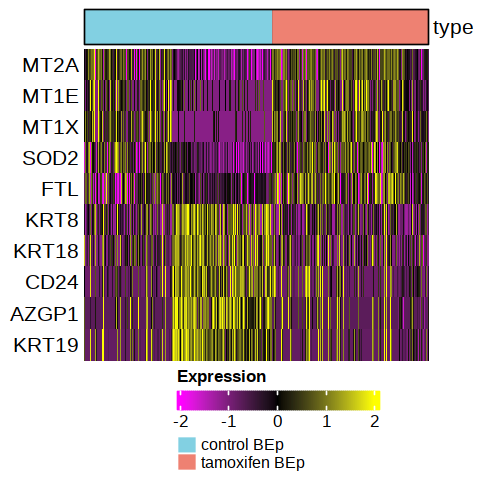

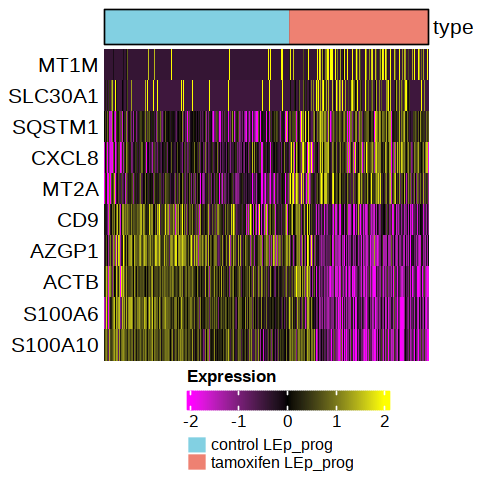

<0 x 0 matrix>

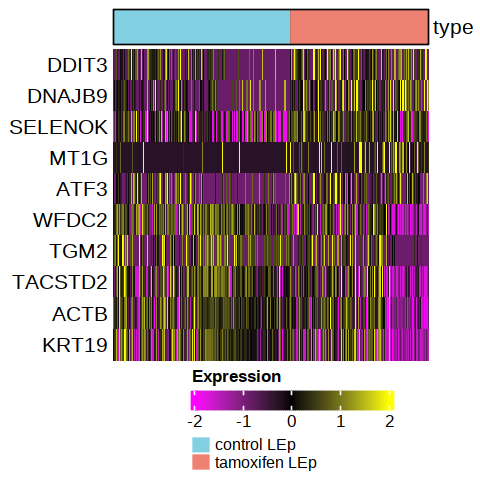

In [21]:
cell_types <- c("BEp", "LEp_prog", "LEp")

df_info <- data.frame()

for (cell_type in cell_types) {
    
    display_html("<hr style=\"height:2px\">")
    log_txt(cell_type)
    
    list_markers <- find_markers(rna, sample1 = sample1,
                        sample_ref = sample_ref,
                        pattern_sample1 = pattern_sample1,
                        pattern_sample_ref = pattern_sample_ref,
                        cell_type1 = cell_type,
                        cell_type_ref = cell_type,
                                 
                        group_name1 = sprintf("%s %s", group_name1, cell_type),
                        group_name_ref = sprintf("%s %s", group_name_ref, cell_type),
                        col_cluster_types = col_cluster_types_,
                        col_cell_types = col_cell_types_,
                        th_log2fc=th_log2fc_,
                        th_padj=th_padj_, 
                        min.pct=min.pct_,
                        min.diff.pct=min.diff.pct_,
                        max.cells.per.ident=max.cells.per.ident_,
                        method_dge = method_dge,
                        n_log = 1)

  if (!is.null(list_markers)) {
    
    head(list_markers$markers)
    dim(list_markers$markers)

    str_condition_tmp <- sprintf("%s_%s_vs_%s_%s",
                               str_condition,
                               group_name_ref, group_name1, cell_type)
    
    list_ea <- execute_enrichment_analysis(list_markers$markers,
                        str_condition_tmp,
                        th_log2fc = th_log2fc_,
                        th_padj = th_padj_)

    genes_up <- rownames(list_ea$df_up)
    genes_dn <- rownames(list_ea$df_dn)
    list_genes_dn[[cell_type]] <- genes_dn

    if (f_featureplot) {
      gg <- featureplot_enrichment_analysis(rna,
                list_ea,
                str_condition_tmp)
    }

    str_condition_tmp_ <- str_condition_tmp
    unlink(sprintf("%s/%s*", figure_format, str_condition_tmp))
    df_dp <- as.data.frame(list_ea[["down peroulab"]])
    if (any(grepl("MCF7.E2.induced.genes", rownames(df_dp)))) {
        df_info[cell_type, "pairs"] <- "E2IG down"
    } else {
        str_condition_tmp_ <- sprintf("%s_no_down_mcf7.e2.induced.genes", str_condition_tmp)
    }
    list_out_heatmap <- heatmap_enrichment_analysis(list_markers,
                    list_ea,
                    str_condition_tmp_,
                    pattern_gene_removal="^MT-|^RPS|^RPL",
                    max_up=5, max_dn=5,
                    n_sampling=n_sampling,
                    cluster_rows=cluster_rows)

  } # if
    
} # for


display(df_info)


# session info

In [22]:

writeLines(capture.output(sessionInfo()), "txt/sessionInfo.txt")


# reference

https://satijalab.org/seurat/


